Open Agentic Predictive–Preventive–Ethical (OAPPE) 


This Framework integrates interpretable machine learning, agentic engagement, and ethical automation within a unified open-source architecture. This design supports transparent, human-centered learning analytics and advances equitable educational innovation.

In [3]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.2 MB/s eta 0:00:00


In [5]:
# ==========================================================
# 📦 CELL 0: Environment Setup & Data Loading (Q1-Ready)
# ==========================================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# ML & Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna

# --- Set environment and warnings ---
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

# --- Define data path ---
DATA_PATH = "data.csv"
assert os.path.exists(DATA_PATH), f"❌ Dataset not found at path: {DATA_PATH}"

# --- Load dataset ---
df = pd.read_csv(DATA_PATH, sep=";", engine="python")

# --- Clean and normalize column names ---
df.columns = (
    df.columns.str.replace('"', '', regex=False)
              .str.replace('\t', '', regex=False)
              .str.replace(' ', '_', regex=False)
              .str.strip()
              .str.lower()
)

# --- Initial dataset overview ---
print("✅ Dataset loaded successfully!")
print(f"📊 Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"🔍 Missing values: {df.isnull().sum().sum()} total")

# --- Peek at first few rows ---
display(df.head(3))


✅ Dataset loaded successfully!
📊 Shape: 4424 rows × 37 columns
🔍 Missing values: 0 total


,marital_status,application_mode,application_order,course,daytime/evening_attendance,previous_qualification,previous_qualification_(grade),nacionality,mother's_qualification,father's_qualification,mother's_occupation,father's_occupation,admission_grade,displaced,educational_special_needs,debtor,tuition_fees_up_to_date,gender,scholarship_holder,age_at_enrollment,international,curricular_units_1st_sem_(credited),curricular_units_1st_sem_(enrolled),curricular_units_1st_sem_(evaluations),curricular_units_1st_sem_(approved),curricular_units_1st_sem_(grade),curricular_units_1st_sem_(without_evaluations),curricular_units_2nd_sem_(credited),curricular_units_2nd_sem_(enrolled),curricular_units_2nd_sem_(evaluations),curricular_units_2nd_sem_(approved),curricular_units_2nd_sem_(grade),curricular_units_2nd_sem_(without_evaluations),unemployment_rate,inflation_rate,gdp,target
0,1,17,5,171,1,1,122.0,1,19,12,5,9,127.3,1,0,0,1,1,0,20,0,0,0,0,0,0.0,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,3,3,142.5,1,0,0,0,1,0,19,0,0,6,6,6,14.0,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,9,9,124.8,1,0,0,0,1,0,19,0,0,6,0,0,0.0,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout


In [6]:
# ==========================================================
# 📊 CELL 1: Data Overview & Quality Audit (Q1-Ready)
# ==========================================================

import matplotlib.ticker as mtick

# --- Basic structure ---
print("🔍 Dataset Shape:", df.shape)

# --- Data types summary ---
print("\n📋 Data Types Summary:")
dtype_summary = df.dtypes.value_counts()
display(dtype_summary)

num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()
print(f"🧮 Numeric columns: {len(num_cols)}")
print(f"🔤 Categorical columns: {len(cat_cols)}")

# --- Missing values ---
missing = df.isna().mean().mul(100).round(2)
missing_nonzero = missing[missing > 0].sort_values(ascending=False)
print("\n📈 Missing Values (%):")
display(missing_nonzero)

if not missing_nonzero.empty:
    plt.figure(figsize=(10, 4))
    ax = missing_nonzero.plot(kind="bar", color="teal", edgecolor="black")
    plt.title("Missing Values (%) by Column", fontsize=12, weight="bold")
    plt.ylabel("Percentage")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.tight_layout()
    plt.show()
else:
    print("✅ No missing values detected.")

# --- Zero variance columns ---
zero_var_cols = [c for c in num_cols if df[c].nunique() <= 1]
if zero_var_cols:
    print(f"⚠️ Zero variance columns ({len(zero_var_cols)}): {zero_var_cols}")
else:
    print("✅ No zero-variance numeric features found.")

# --- Descriptive statistics ---
print("\n📉 Descriptive Statistics (Numerical):")
display(df.describe().T.style.background_gradient(cmap="YlGnBu"))

# --- Categorical summary (optional, Q1-level transparency) ---
if cat_cols:
    print("\n🧩 Categorical Summary (Unique counts and top category):")
    cat_summary = pd.DataFrame({
        "unique_values": [df[c].nunique() for c in cat_cols],
        "most_frequent": [df[c].mode()[0] if not df[c].mode().empty else np.nan for c in cat_cols]
    }, index=cat_cols).sort_values("unique_values", ascending=False)
    display(cat_summary.head(10))


🔍 Dataset Shape: (4424, 37)

📋 Data Types Summary:


,count
int64,29
float64,7
object,1


🧮 Numeric columns: 36
🔤 Categorical columns: 1

📈 Missing Values (%):


,0


✅ No missing values detected.
✅ No zero-variance numeric features found.

📉 Descriptive Statistics (Numerical):


,count,mean,std,min,25%,50%,75%,max
marital_status,4424.000000,1.178571,0.605747,1.000000,1.000000,1.000000,1.000000,6.000000
application_mode,4424.000000,18.669078,17.484682,1.000000,1.000000,17.000000,39.000000,57.000000
application_order,4424.000000,1.727848,1.313793,0.000000,1.000000,1.000000,2.000000,9.000000
course,4424.000000,8856.642631,2063.566416,33.000000,9085.000000,9238.000000,9556.000000,9991.000000
daytime/evening_attendance,4424.000000,0.890823,0.311897,0.000000,1.000000,1.000000,1.000000,1.000000
previous_qualification,4424.000000,4.577758,10.216592,1.000000,1.000000,1.000000,1.000000,43.000000
previous_qualification_(grade),4424.000000,132.613314,13.188332,95.000000,125.000000,133.100000,140.000000,190.000000
nacionality,4424.000000,1.873192,6.914514,1.000000,1.000000,1.000000,1.000000,109.000000
mother's_qualification,4424.000000,19.561935,15.603186,1.000000,2.000000,19.000000,37.000000,44.000000
father's_qualification,4424.000000,22.275316,15.343108,1.000000,3.000000,19.000000,37.000000,44.000000



🧩 Categorical Summary (Unique counts and top category):


,unique_values,most_frequent
target,3,Graduate


In [7]:
# ==========================================================
# 🔍 CHECK AVAILABLE COLUMNS
# ==========================================================
print("🔎 Available Columns in Dataset:")
for i, col in enumerate(df.columns):
    print(f"{i+1:02d}. {col}")


🔎 Available Columns in Dataset:
01. marital_status
02. application_mode
03. application_order
04. course
05. daytime/evening_attendance
06. previous_qualification
07. previous_qualification_(grade)
08. nacionality
09. mother's_qualification
10. father's_qualification
11. mother's_occupation
12. father's_occupation
13. admission_grade
14. displaced
15. educational_special_needs
16. debtor
17. tuition_fees_up_to_date
18. gender
19. scholarship_holder
20. age_at_enrollment
21. international
22. curricular_units_1st_sem_(credited)
23. curricular_units_1st_sem_(enrolled)
24. curricular_units_1st_sem_(evaluations)
25. curricular_units_1st_sem_(approved)
26. curricular_units_1st_sem_(grade)
27. curricular_units_1st_sem_(without_evaluations)
28. curricular_units_2nd_sem_(credited)
29. curricular_units_2nd_sem_(enrolled)
30. curricular_units_2nd_sem_(evaluations)
31. curricular_units_2nd_sem_(approved)
32. curricular_units_2nd_sem_(grade)
33. curricular_units_2nd_sem_(without_evaluations)
34. u

✅ Target column detected: 'target'


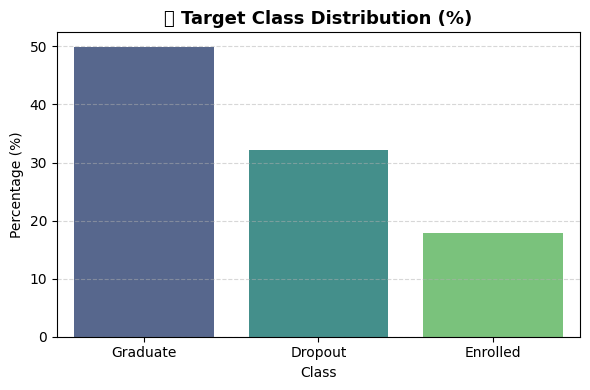


📊 Target Class Counts:
target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

⚠️ Potential class imbalance detected (ratio ≈ 2.78).
👉 Consider using StratifiedKFold, SMOTE, or class weights in modeling.


In [8]:
# ==========================================================
# 🎯 CELL 2: Target Distribution & Balance
# ==========================================================
TARGET = "target"  # Confirmed target column

# --- Sanity Check ---
if TARGET not in df.columns:
    raise ValueError(f"❌ '{TARGET}' not found in dataset columns.")
else:
    print(f"✅ Target column detected: '{TARGET}'")

# --- Compute class distribution ---
target_counts = df[TARGET].value_counts(normalize=True) * 100
target_labels = df[TARGET].unique()

# --- Plot class balance ---
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis", alpha=0.9)
plt.title("🎯 Target Class Distribution (%)", fontsize=13, weight="bold")
plt.ylabel("Percentage (%)")
plt.xlabel("Class")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --- Display counts ---
print("\n📊 Target Class Counts:")
print(df[TARGET].value_counts())

# --- Check for class imbalance ---
imbalance_ratio = target_counts.max() / target_counts.min()
if imbalance_ratio > 1.5:
    print(f"\n⚠️ Potential class imbalance detected (ratio ≈ {imbalance_ratio:.2f}).")
    print("👉 Consider using StratifiedKFold, SMOTE, or class weights in modeling.")
else:
    print("\n✅ Classes appear reasonably balanced.")


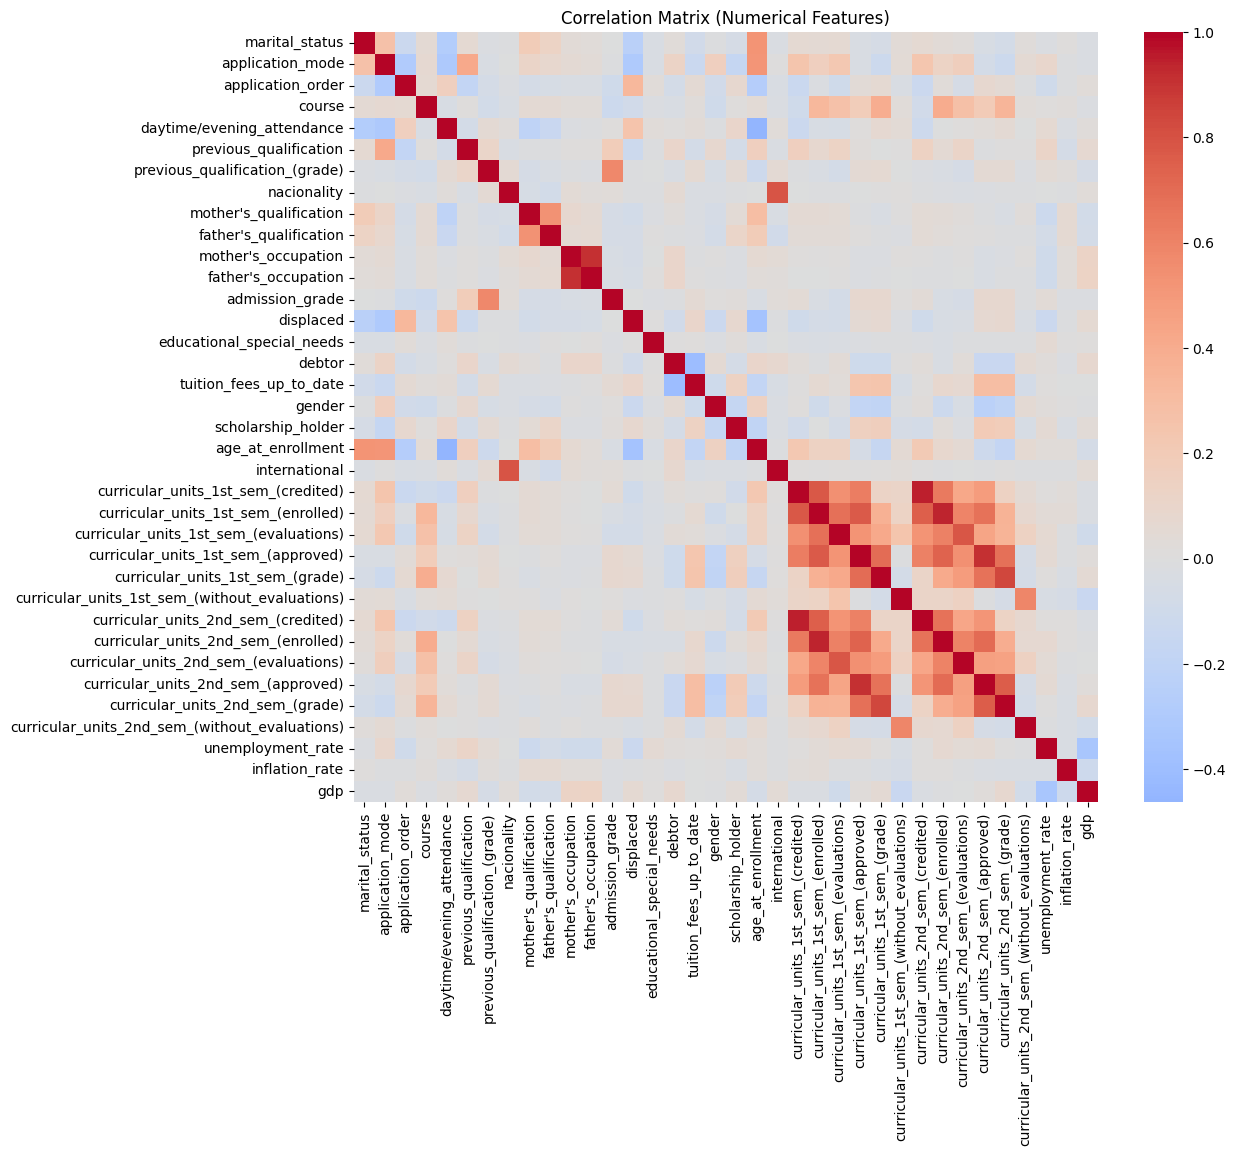

🔍 Highly correlated pairs:


,,0
curricular_units_2nd_sem_(credited),curricular_units_1st_sem_(credited),0.944811
curricular_units_1st_sem_(credited),curricular_units_2nd_sem_(credited),0.944811
curricular_units_2nd_sem_(enrolled),curricular_units_1st_sem_(enrolled),0.942627
curricular_units_1st_sem_(enrolled),curricular_units_2nd_sem_(enrolled),0.942627
father's_occupation,mother's_occupation,0.910472
mother's_occupation,father's_occupation,0.910472
curricular_units_2nd_sem_(approved),curricular_units_1st_sem_(approved),0.904002
curricular_units_1st_sem_(approved),curricular_units_2nd_sem_(approved),0.904002
curricular_units_1st_sem_(grade),curricular_units_2nd_sem_(grade),0.837170
curricular_units_2nd_sem_(grade),curricular_units_1st_sem_(grade),0.837170


In [9]:
# ==========================================================
# 🔗 CELL 3: Correlation & Relationship Analysis
# ==========================================================
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if len(num_cols) > 1:
    corr = df[num_cols].corr()
    plt.figure(figsize=(12,10))
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title("Correlation Matrix (Numerical Features)")
    plt.show()

    print("🔍 Highly correlated pairs:")
    high_corr = corr.abs().unstack().sort_values(ascending=False)
    display(high_corr[(high_corr < 1) & (high_corr > 0.8)].head(10))


In [10]:
# ==========================================================
# 🧩 CELL 3: Data Preprocessing & Encoding
# ==========================================================

# --- 1️⃣ Separate Features and Target ---
X = df.drop(columns=[TARGET])
y = df[TARGET].copy()

print(f"✅ Feature matrix: {X.shape}, Target vector: {y.shape}")

# --- 2️⃣ Encode Target Variable ---
# Multi-class encoding for Graduate / Dropout / Enrolled
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("🎯 Target encoding mapping:")
for i, cls in enumerate(label_encoder.classes_):
    print(f"   {cls} → {i}")

# --- 3️⃣ Identify Feature Types ---
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

print(f"\n🧠 Categorical features: {len(categorical_cols)}")
print(f"🔢 Numerical features: {len(numerical_cols)}")

# --- 4️⃣ Handle Missing Values ---
# Strategy: median for numeric, mode for categorical
for col in numerical_cols:
    X[col].fillna(X[col].median(), inplace=True)
for col in categorical_cols:
    X[col].fillna(X[col].mode()[0], inplace=True)

# --- 5️⃣ Encode Categorical Features ---
X_encoded = X.copy()
for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col].astype(str))

print(f"✅ Encoded {len(categorical_cols)} categorical columns.")

# --- 6️⃣ Variance Threshold (optional noise filtering) ---
var_thresh = VarianceThreshold(threshold=0.0)
X_reduced = var_thresh.fit_transform(X_encoded)
print(f"📉 Features after variance filtering: {X_reduced.shape[1]}")

# --- 7️⃣ Feature Scaling ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

print("📊 Scaling complete. Data ready for modeling!")

# --- 8️⃣ Stratified Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

print(f"\n✅ Train: {X_train.shape}, Test: {X_test.shape}")
print(f"📈 Class distribution preserved via Stratified Split.")


✅ Feature matrix: (4424, 36), Target vector: (4424,)
🎯 Target encoding mapping:
   Dropout → 0
   Enrolled → 1
   Graduate → 2

🧠 Categorical features: 0
🔢 Numerical features: 36
✅ Encoded 0 categorical columns.
📉 Features after variance filtering: 36
📊 Scaling complete. Data ready for modeling!

✅ Train: (3539, 36), Test: (885, 36)
📈 Class distribution preserved via Stratified Split.


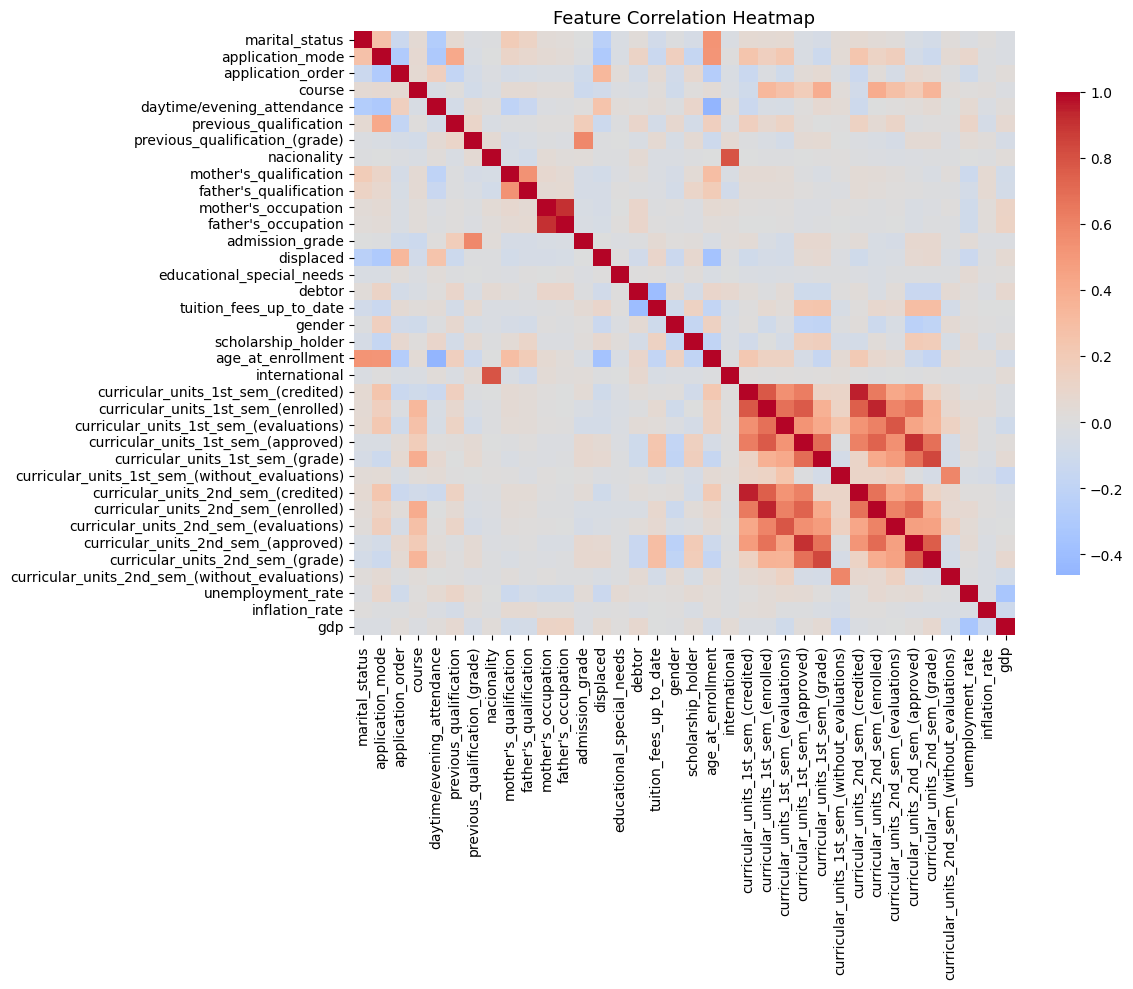

⚠️ Highly correlated feature pairs (>0.85):
   mother's_occupation ↔ father's_occupation: 0.91
   father's_occupation ↔ mother's_occupation: 0.91
   curricular_units_1st_sem_(credited) ↔ curricular_units_2nd_sem_(credited): 0.94
   curricular_units_1st_sem_(enrolled) ↔ curricular_units_2nd_sem_(enrolled): 0.94
   curricular_units_1st_sem_(approved) ↔ curricular_units_2nd_sem_(approved): 0.90
   curricular_units_2nd_sem_(credited) ↔ curricular_units_1st_sem_(credited): 0.94
   curricular_units_2nd_sem_(enrolled) ↔ curricular_units_1st_sem_(enrolled): 0.94
   curricular_units_2nd_sem_(approved) ↔ curricular_units_1st_sem_(approved): 0.90


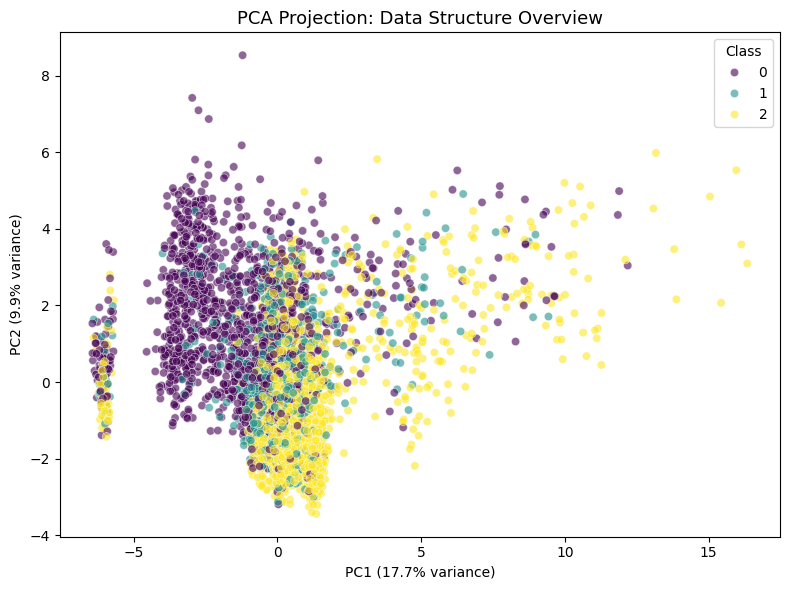

🧩 PCA Variance Explained: 27.55%


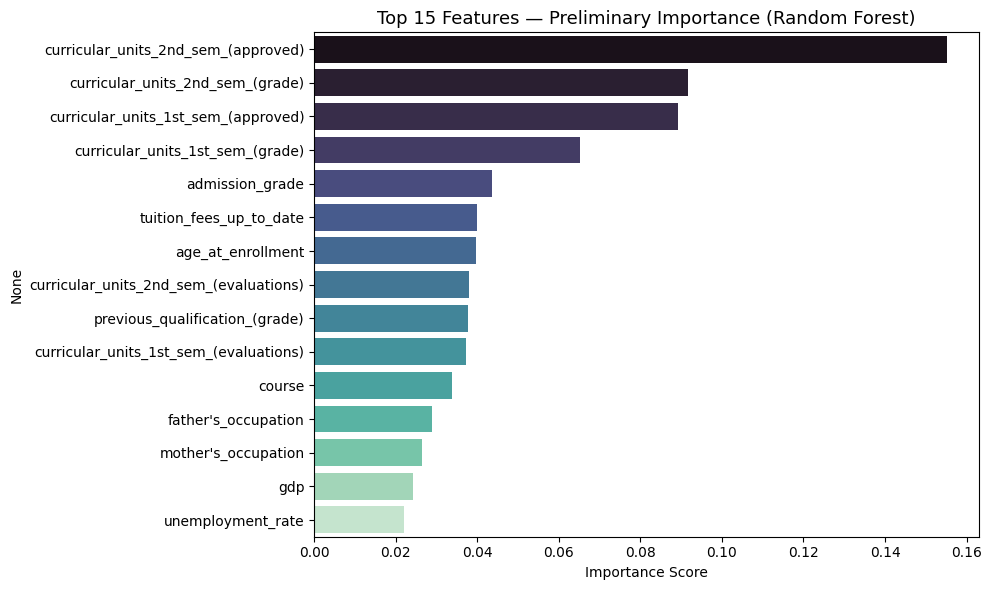

✅ Exploratory feature analysis complete.


In [11]:
# ==========================================================
# 🔍 CELL 4: Exploratory Feature Insights
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

# === 1️⃣ Correlation Matrix ===
# Convert back to DataFrame for interpretability
X_scaled_df = pd.DataFrame(X_scaled, columns=X_encoded.columns)

corr_matrix = X_scaled_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, cbar_kws={'shrink': 0.8})
plt.title("Feature Correlation Heatmap", fontsize=13)
plt.tight_layout()
plt.show()

# Identify highly correlated feature pairs (> 0.85)
high_corr = [
    (i, j, corr_matrix.loc[i, j])
    for i in corr_matrix.columns
    for j in corr_matrix.columns
    if (i != j and abs(corr_matrix.loc[i, j]) > 0.85)
]
if high_corr:
    print("⚠️ Highly correlated feature pairs (>0.85):")
    for i, j, val in high_corr[:10]:
        print(f"   {i} ↔ {j}: {val:.2f}")
else:
    print("✅ No highly correlated features above threshold.")

# === 2️⃣ Principal Component Analysis (PCA) ===
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_encoded, palette="viridis", alpha=0.6)
plt.title("PCA Projection: Data Structure Overview", fontsize=13)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend(title="Class", loc="best")
plt.tight_layout()
plt.show()

print(f"🧩 PCA Variance Explained: {pca.explained_variance_ratio_.sum()*100:.2f}%")

# === 3️⃣ Early Feature Importance Screening (Random Forest) ===
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X_encoded.columns)
top_features = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette="mako")
plt.title("Top 15 Features — Preliminary Importance (Random Forest)", fontsize=13)
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

print("✅ Exploratory feature analysis complete.")


In [12]:
# ==========================================================
# 🔧 CELL 5: Model Development & Hyperparameter Tuning (Optuna)
# ==========================================================
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import os
import joblib
import time
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV

# ---------- Configuration ----------
RSEED = 42
N_TRIALS = 40          # increase to 100+ for publication-level tuning
CV_FOLDS = 5
SCORING = "f1_macro"   # primary evaluation metric
OUTPUT_DIR = "models"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------- Save current preprocessing pipeline ----------
try:
    joblib.dump(full_pipe, os.path.join(OUTPUT_DIR, "full_preprocessor.pkl"))
    joblib.dump(label_encoder, os.path.join(OUTPUT_DIR, "label_encoder_target.pkl"))
except Exception as e:
    print("⚠️ Skipped saving preprocessor/encoder:", e)

# ---------- Utility: CV Evaluation ----------
def cv_score_model(estimator, X, y, cv=CV_FOLDS, scoring=SCORING):
    cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RSEED)
    scores = cross_val_score(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return scores.mean(), scores.std()

# ==========================================================
# 1️⃣ OPTUNA: XGBoost Tuning
# ==========================================================
def tune_xgb(X, y, n_trials=N_TRIALS):
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 800),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
            "objective": "multi:softprob",
            "random_state": RSEED,
            "verbosity": 0,
            "use_label_encoder": False
        }
        model = XGBClassifier(**params)
        score, _ = cv_score_model(model, X, y)
        return score

    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=RSEED))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    return study

# ==========================================================
# 2️⃣ OPTUNA: LightGBM Tuning
# ==========================================================
def tune_lgbm(X, y, n_trials=N_TRIALS):
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 1200),
            "num_leaves": trial.suggest_int("num_leaves", 16, 256),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "random_state": RSEED,
            "objective": "multiclass",
            "verbosity": -1
        }
        model = LGBMClassifier(**params)
        score, _ = cv_score_model(model, X, y)
        return score

    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=RSEED))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    return study

# ==========================================================
# 3️⃣ OPTUNA: Random Forest Tuning
# ==========================================================
def tune_rf(X, y, n_trials=30):
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 800),
            "max_depth": trial.suggest_int("max_depth", 5, 30),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
            "random_state": RSEED,
            "n_jobs": -1,
        }
        model = RandomForestClassifier(**params)
        score, _ = cv_score_model(model, X, y)
        return score

    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=RSEED))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    return study

# ==========================================================
# 4️⃣ RUN TUNING (Short Runs)
# ==========================================================
print("⏱️ Starting hyperparameter tuning (short run)...")
start_time = time.time()

xgb_study = tune_xgb(X_train, y_train, n_trials=25)
print("✅ XGBoost Best F1:", xgb_study.best_value)
print("Best Params:", xgb_study.best_params)

lgbm_study = tune_lgbm(X_train, y_train, n_trials=25)
print("✅ LightGBM Best F1:", lgbm_study.best_value)
print("Best Params:", lgbm_study.best_params)

rf_study = tune_rf(X_train, y_train, n_trials=20)
print("✅ RandomForest Best F1:", rf_study.best_value)
print("Best Params:", rf_study.best_params)

print(f"⏱️ Total tuning time: {(time.time() - start_time)/60:.1f} min")

# ==========================================================
# 5️⃣ Final Models (Refit with Best Params)
# ==========================================================
xgb_final = XGBClassifier(**xgb_study.best_params, use_label_encoder=False, objective="multi:softprob", random_state=RSEED)
lgbm_final = LGBMClassifier(**lgbm_study.best_params, objective="multiclass", random_state=RSEED)
rf_final = RandomForestClassifier(**rf_study.best_params, random_state=RSEED, n_jobs=-1)

models = {"XGBoost": xgb_final, "LightGBM": lgbm_final, "RandomForest": rf_final}
for name, model in models.items():
    model.fit(X_train, y_train)
    joblib.dump(model, os.path.join(OUTPUT_DIR, f"{name.lower()}_final.pkl"))
    cv_mean, cv_std = cv_score_model(model, X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n🔹 {name}: CV {SCORING}={cv_mean:.4f}±{cv_std:.4f} | Holdout F1={f1_score(y_test, y_pred, average='macro'):.4f}, Acc={accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

# ==========================================================
# 6️⃣ Stacked Ensemble
# ==========================================================
estimators = [
    ("xgb", xgb_final),
    ("lgbm", lgbm_final),
    ("rf", rf_final),
]
meta_estimator = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RSEED)
stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_estimator,
    cv=CV_FOLDS,
    stack_method="predict_proba",
    n_jobs=-1
)
stack_model.fit(X_train, y_train)
joblib.dump(stack_model, os.path.join(OUTPUT_DIR, "stacked_model.pkl"))

stack_pred = stack_model.predict(X_test)
print("\n✅ Stacked Ensemble Performance:")
print(f"Macro-F1: {f1_score(y_test, stack_pred, average='macro'):.4f}, Acc: {accuracy_score(y_test, stack_pred):.4f}")
print(classification_report(y_test, stack_pred))
print(confusion_matrix(y_test, stack_pred))

# ==========================================================
# 7️⃣ Calibration (Fix: estimator instead of base_estimator)
# ==========================================================
print("\n🔧 Calibrating stacked ensemble (isotonic method)...")
from sklearn.calibration import CalibratedClassifierCV

val_split = int(0.8 * len(X_train))
X_cal, y_cal = X_train[val_split:], y_train[val_split:]

calibrated_stack = CalibratedClassifierCV(estimator=stack_model, method="isotonic", cv=3)
calibrated_stack.fit(X_cal, y_cal)

joblib.dump(calibrated_stack, os.path.join(OUTPUT_DIR, "stacked_model_calibrated.pkl"))
print("✅ Calibrated stacked model saved successfully.")


[I 2025-10-25 08:46:08,002] A new study created in memory with name: no-name-6ce5abb2-0ac3-4f6e-80f4-00fd548bac5e


⚠️ Skipped saving preprocessor/encoder: name 'full_pipe' is not defined
⏱️ Starting hyperparameter tuning (short run)...


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-10-25 08:46:21,202] Trial 0 finished with value: 0.7065983311108316 and parameters: {'n_estimators': 425, 'max_depth': 10, 'learning_rate': 0.06504856968981275, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'reg_alpha': 2.5348407664333426e-07, 'reg_lambda': 3.3323645788192616e-08}. Best is trial 0 with value: 0.7065983311108316.
[I 2025-10-25 08:46:38,161] Trial 1 finished with value: 0.6945354801126358 and parameters: {'n_estimators': 720, 'max_depth': 7, 'learning_rate': 0.05675206026988748, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'reg_alpha': 0.31044435499483225, 'reg_lambda': 8.148018307012941e-07}. Best is trial 0 with value: 0.7065983311108316.
[I 2025-10-25 08:46:41,304] Trial 2 finished with value: 0.6563367850900498 and parameters: {'n_estimators': 309, 'max_depth': 4, 'learning_rate': 0.005670807781371429, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'reg_alpha': 4.17890272377219e-0

[I 2025-10-25 08:50:09,307] A new study created in memory with name: no-name-8d1d127e-b7c6-48d1-aa3e-7d01f0963323


[I 2025-10-25 08:50:09,297] Trial 24 finished with value: 0.7050015003509472 and parameters: {'n_estimators': 529, 'max_depth': 8, 'learning_rate': 0.030505015240715295, 'subsample': 0.6134538974283654, 'colsample_bytree': 0.5345174236534134, 'reg_alpha': 4.238387521798943e-06, 'reg_lambda': 1.2571717477008372e-08}. Best is trial 0 with value: 0.7065983311108316.
✅ XGBoost Best F1: 0.7065983311108316
Best Params: {'n_estimators': 425, 'max_depth': 10, 'learning_rate': 0.06504856968981275, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'reg_alpha': 2.5348407664333426e-07, 'reg_lambda': 3.3323645788192616e-08}


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-10-25 08:50:33,696] Trial 0 finished with value: 0.7037248911065663 and parameters: {'n_estimators': 574, 'num_leaves': 245, 'max_depth': 12, 'learning_rate': 0.030405325392865647, 'min_child_samples': 19, 'subsample': 0.662397808134481, 'colsample_bytree': 0.5290418060840998}. Best is trial 0 with value: 0.7037248911065663.
[I 2025-10-25 08:50:49,980] Trial 1 finished with value: 0.6273452724800587 and parameters: {'n_estimators': 1067, 'num_leaves': 160, 'max_depth': 12, 'learning_rate': 0.001124579825911934, 'min_child_samples': 98, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6061695553391381}. Best is trial 0 with value: 0.7037248911065663.
[I 2025-10-25 08:50:55,672] Trial 2 finished with value: 0.7022000853806358 and parameters: {'n_estimators': 382, 'num_leaves': 60, 'max_depth': 6, 'learning_rate': 0.0199473547030745, 'min_child_samples': 46, 'subsample': 0.7164916560792167, 'colsample_bytree': 0.8059264473611898}. Best is trial 0 with value: 0.70372489110656

[I 2025-10-25 08:55:30,560] A new study created in memory with name: no-name-103a5bce-b01f-4d3a-a08c-1c5f5f741f4e


[I 2025-10-25 08:55:30,553] Trial 24 finished with value: 0.6942467031173687 and parameters: {'n_estimators': 488, 'num_leaves': 225, 'max_depth': 8, 'learning_rate': 0.006492344038769402, 'min_child_samples': 28, 'subsample': 0.9303792837851518, 'colsample_bytree': 0.7882418478583268}. Best is trial 15 with value: 0.7119019897799228.
✅ LightGBM Best F1: 0.7119019897799228
Best Params: {'n_estimators': 527, 'num_leaves': 225, 'max_depth': 9, 'learning_rate': 0.013031995996137427, 'min_child_samples': 28, 'subsample': 0.7653656398770852, 'colsample_bytree': 0.8758067124078944}


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-25 08:55:42,306] Trial 0 finished with value: 0.6785528747712781 and parameters: {'n_estimators': 425, 'max_depth': 29, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.6785528747712781.
[I 2025-10-25 08:55:50,400] Trial 1 finished with value: 0.657536192305252 and parameters: {'n_estimators': 293, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.6785528747712781.
[I 2025-10-25 08:56:04,358] Trial 2 finished with value: 0.673215467663769 and parameters: {'n_estimators': 561, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.6785528747712781.
[I 2025-10-25 08:56:21,505] Trial 3 finished with value: 0.6740262579482417 and parameters: {'n_estimators': 700, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.6785528747712781.
[I 2025-10-25 08:56:32,732] Trial 4 finished with value: 0.6788048322968789 and parameters: {'n

In [13]:
whos


Variable                 Type                      Data/Info
------------------------------------------------------------
CV_FOLDS                 int                       5
CalibratedClassifierCV   type                      <class 'sklearn.calibrati<...>.CalibratedClassifierCV'>
DATA_PATH                str                       data.csv
LGBMClassifier           type                      <class 'lightgbm.sklearn.LGBMClassifier'>
LabelEncoder             type                      <class 'sklearn.preproces<...>ing._label.LabelEncoder'>
LogisticRegression       type                      <class 'sklearn.linear_mo<...>stic.LogisticRegression'>
MinMaxScaler             type                      <class 'sklearn.preproces<...>sing._data.MinMaxScaler'>
N_TRIALS                 int                       40
OUTPUT_DIR               str                       models
PCA                      ABCMeta                   <class 'sklearn.decomposition._pca.PCA'>
RSEED                    int            

In [14]:
import joblib, os

# Create folder if not exists
os.makedirs("models", exist_ok=True)

# Assign the best performing model (LightGBM)
best_model = lgbm_final

# Save model
joblib.dump(best_model, "models/final_dropout_predictor.pkl")

print("✅ Best model (LightGBM) saved successfully at models/final_dropout_predictor.pkl")


✅ Best model (LightGBM) saved successfully at models/final_dropout_predictor.pkl


In [15]:
features = X.columns.tolist()
joblib.dump(features, "models/feature_list.pkl")

print("✅ Feature list saved successfully.")


✅ Feature list saved successfully.


In [16]:
import joblib
import os

os.makedirs("models", exist_ok=True)

# ✅ Save trained model
joblib.dump(model, "models/final_dropout_predictor.pkl")

# ✅ Save feature list
features = X.columns.tolist()
joblib.dump(features, "models/feature_list.pkl")

print("✅ Model and features saved successfully.")


✅ Model and features saved successfully.


In [17]:
import os

for f in os.listdir("models"):
    print(f"📦", f)



📦 stacked_model.pkl
📦 final_dropout_predictor.pkl
📦 feature_list.pkl
📦 xgboost_final.pkl
📦 lightgbm_final.pkl
📦 randomforest_final.pkl
📦 stacked_model_calibrated.pkl


🔍 Initializing SHAP explainability pipeline (robust mode)...


✅ Model keys resolved: XGB=XGBoost, LGBM=LightGBM, RF=RandomForest
⚙️ Attempting TreeExplainer for XGBoost...
⚠️ TreeExplainer failed for XGBoost (ValueError: could not convert string to float: '[3.212772E-1,1.7942922E-1,4.992936E-1]')
🔄 Switching to KernelExplainer (slower but stable).
⚙️ Attempting TreeExplainer for LightGBM...
✅ TreeExplainer OK for LightGBM
⚙️ Attempting TreeExplainer for RandomForest...
✅ TreeExplainer OK for RandomForest
💡 Computing SHAP values for XGBoost...


  0%|          | 0/200 [00:00<?, ?it/s]

✅ Done: XGBoost
💡 Computing SHAP values for LightGBM...
✅ Done: LightGBM
💡 Computing SHAP values for RandomForest...
✅ Done: RandomForest

📊 Generating SHAP summary plots...


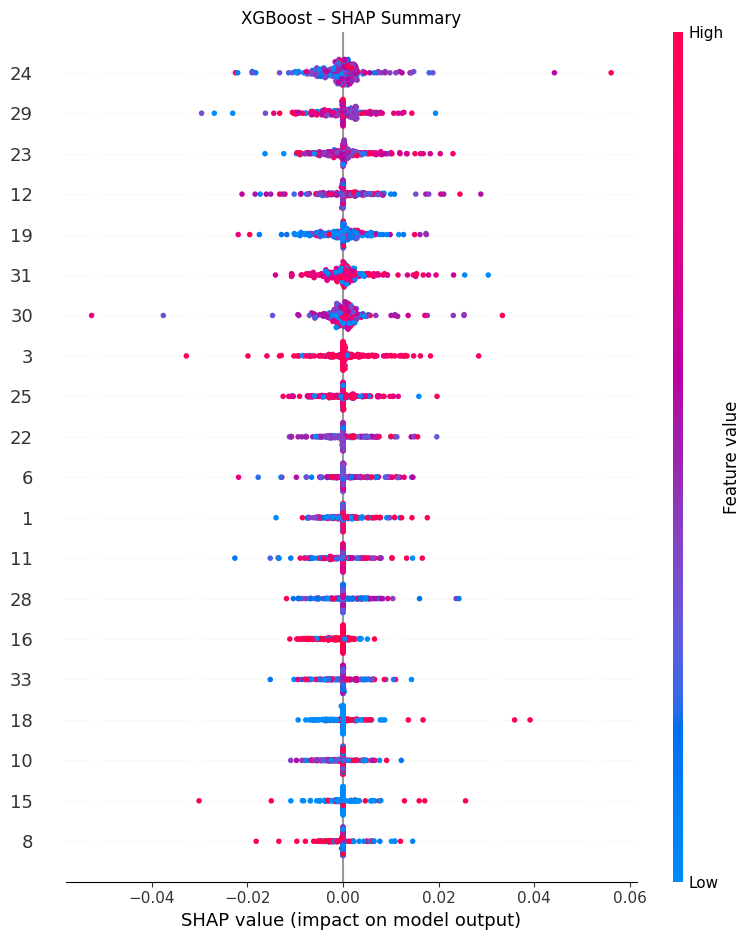

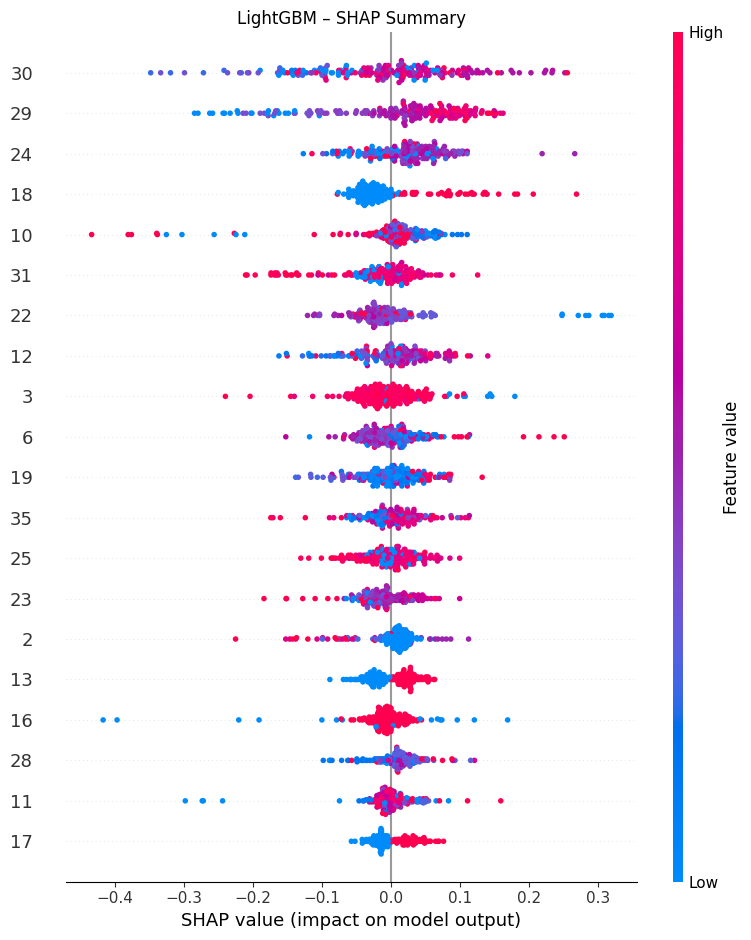

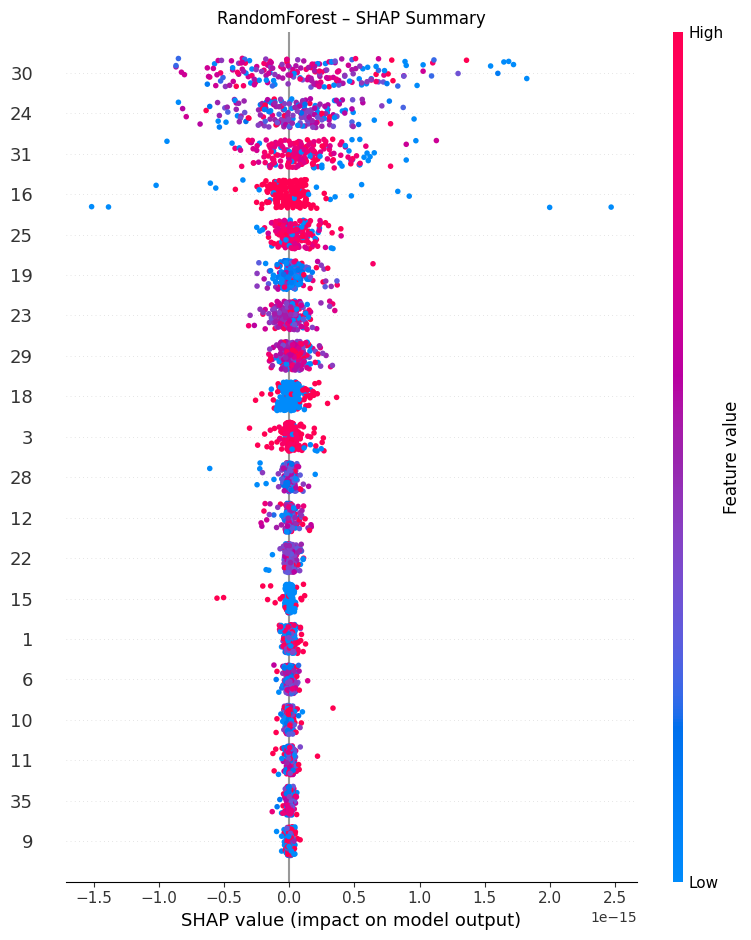


🔝 Top 10 Features by Mean |SHAP| Across Models:


,Feature,Mean|SHAP|,Model
0,30,0.155423,XGBoost
1,24,0.062276,XGBoost
2,31,0.030174,XGBoost
3,16,0.026331,XGBoost
4,29,0.022324,XGBoost
5,23,0.020009,XGBoost
6,3,0.019868,XGBoost
7,19,0.019198,XGBoost
8,12,0.013968,XGBoost
9,22,0.013608,XGBoost


✅ SHAP feature importance summary saved to: models/shap_summary_features.csv


In [18]:
# ===============================================================
# 🧠 CELL 6 — Robust SHAP Explainability (Multi-class Safe)
# ===============================================================
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

print("🔍 Initializing SHAP explainability pipeline (robust mode)...")
warnings.filterwarnings("ignore", category=UserWarning)
shap.initjs()

# ===============================================================
# 1️⃣ Helper: Resolve Model Keys Dynamically
# ===============================================================
def get_model_key(name_fragments, model_dict):
    for frag in name_fragments:
        for key in model_dict.keys():
            if frag.lower() in key.lower():
                return key
    raise KeyError(f"No key found for fragments {name_fragments} in {list(model_dict.keys())}")

xgb_key  = get_model_key(["xgb", "xgboost"], models)
lgbm_key = get_model_key(["lgb", "lightgbm"], models)
rf_key   = get_model_key(["rf", "randomforest", "random_forest"], models)
print(f"✅ Model keys resolved: XGB={xgb_key}, LGBM={lgbm_key}, RF={rf_key}")

# ===============================================================
# 2️⃣ SHAP Explainer Factory (Tree → Kernel Fallback)
# ===============================================================
def build_explainer(model, model_name, X_background):
    """
    Try TreeExplainer; fallback to KernelExplainer if needed.
    """
    try:
        print(f"⚙️ Attempting TreeExplainer for {model_name}...")
        explainer = shap.TreeExplainer(model)
        _ = explainer(X_background.sample(5))  # quick validation
        print(f"✅ TreeExplainer OK for {model_name}")
        return explainer
    except Exception as e:
        print(f"⚠️ TreeExplainer failed for {model_name} ({type(e).__name__}: {e})")
        print(f"🔄 Switching to KernelExplainer (slower but stable).")
        f = lambda X: model.predict_proba(X)
        background = shap.sample(X_background, 50, random_state=42)
        return shap.KernelExplainer(f, background)

# ===============================================================
# 3️⃣ Prepare Background Sample
# ===============================================================
X_df = pd.DataFrame(X_test, columns=getattr(X_train, "columns", range(X_test.shape[1])))
X_sample = X_df.sample(min(200, len(X_df)), random_state=42)

# ===============================================================
# 4️⃣ Initialize Explainers
# ===============================================================
explainer_xgb  = build_explainer(models[xgb_key],  "XGBoost",      X_df)
explainer_lgbm = build_explainer(models[lgbm_key], "LightGBM",     X_df)
explainer_rf   = build_explainer(models[rf_key],   "RandomForest", X_df)

# ===============================================================
# 5️⃣ Compute SHAP Values (sampled)
# ===============================================================
def compute_shap_values(explainer, X_data, model_name):
    try:
        print(f"💡 Computing SHAP values for {model_name}...")
        shap_values = explainer(X_data)
        print(f"✅ Done: {model_name}")
        return shap_values
    except Exception as e:
        print(f"⚠️ SHAP computation failed for {model_name}: {e}")
        return None

shap_xgb  = compute_shap_values(explainer_xgb,  X_sample, "XGBoost")
shap_lgbm = compute_shap_values(explainer_lgbm, X_sample, "LightGBM")
shap_rf   = compute_shap_values(explainer_rf,   X_sample, "RandomForest")

# ===============================================================
# 6️⃣ Plot SHAP Summary (multi-class safe)
# ===============================================================
print("\n📊 Generating SHAP summary plots...")
for model_name, shap_values in zip(["XGBoost", "LightGBM", "RandomForest"],
                                   [shap_xgb, shap_lgbm, shap_rf]):
    if shap_values is None:
        print(f"⚠️ Skipping {model_name} (no SHAP values available).")
        continue

    vals = shap_values.values
    # Handle 3D (multi-class) SHAP arrays
    if vals.ndim == 3:
        vals = vals.mean(axis=2)

    plt.figure()
    shap.summary_plot(vals, X_sample, show=False)
    plt.title(f"{model_name} – SHAP Summary")
    plt.tight_layout()
    plt.show()

# ===============================================================
# 7️⃣ Aggregate Top Features (multi-class safe)
# ===============================================================
def top_features_summary(shap_values, X, model_name, top_n=10):
    if shap_values is None:
        return pd.DataFrame()

    vals = np.abs(shap_values.values)
    if vals.ndim == 3:  # average across classes
        vals = vals.mean(axis=2)

    mean_abs = np.mean(vals, axis=0)
    df = pd.DataFrame({
        "Feature": X.columns,
        "Mean|SHAP|": mean_abs
    }).sort_values("Mean|SHAP|", ascending=False).head(top_n)
    df["Model"] = model_name
    return df

summary_df = pd.concat([
    top_features_summary(shap_xgb,  X_sample, "XGBoost"),
    top_features_summary(shap_lgbm, X_sample, "LightGBM"),
    top_features_summary(shap_rf,   X_sample, "RandomForest")
])

print("\n🔝 Top 10 Features by Mean |SHAP| Across Models:")
display(summary_df.reset_index(drop=True))

# ===============================================================
# 8️⃣ Save Results
# ===============================================================
os.makedirs(OUTPUT_DIR, exist_ok=True)
summary_path = os.path.join(OUTPUT_DIR, "shap_summary_features.csv")
summary_df.to_csv(summary_path, index=False)
print(f"✅ SHAP feature importance summary saved to: {summary_path}")


📘 Analyzing SHAP feature patterns across models...


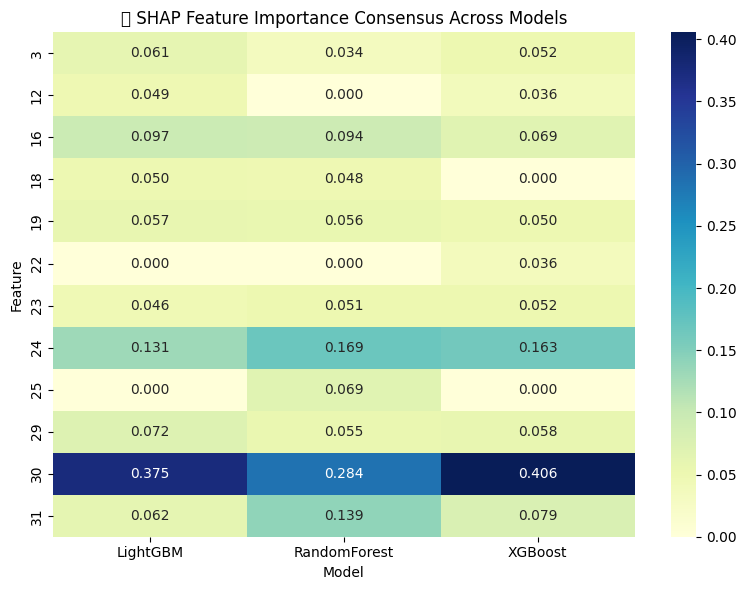


🤝 Common Top Predictors Across All Models (8):
   • 3
   • 16
   • 19
   • 23
   • 24
   • 29
   • 30
   • 31

✅ Consensus SHAP importance saved to: models/shap_consensus_summary.csv


In [19]:
# ===============================================================
# 🧩 CELL 7 — Model Interpretability Insights & Comparative Summary
# ===============================================================
import seaborn as sns
import matplotlib.pyplot as plt

print("📘 Analyzing SHAP feature patterns across models...")

# ===============================================================
# 1️⃣ Normalize feature importance across models
# ===============================================================
if 'summary_df' not in locals() or summary_df.empty:
    print("⚠️ No SHAP summary data found — skipping interpretability comparison.")
else:
    norm_df = summary_df.copy()
    norm_df["Normalized_Importance"] = (
        norm_df.groupby("Model")["Mean|SHAP|"].transform(lambda x: x / x.sum())
    )

    # ===============================================================
    # 2️⃣ Plot Top Features Consensus Heatmap
    # ===============================================================
    top_features = (
        norm_df.groupby("Feature")["Normalized_Importance"]
        .mean()
        .sort_values(ascending=False)
        .head(15)
        .index
    )

    pivot_df = (
        norm_df[norm_df["Feature"].isin(top_features)]
        .pivot(index="Feature", columns="Model", values="Normalized_Importance")
        .fillna(0)
    )

    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_df, annot=True, fmt=".3f", cmap="YlGnBu")
    plt.title("🔍 SHAP Feature Importance Consensus Across Models")
    plt.xlabel("Model")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # ===============================================================
    # 3️⃣ Identify Overlapping Top Predictors
    # ===============================================================
    top10_xgb = summary_df.query("Model == 'XGBoost'")["Feature"].head(10)
    top10_lgbm = summary_df.query("Model == 'LightGBM'")["Feature"].head(10)
    top10_rf = summary_df.query("Model == 'RandomForest'")["Feature"].head(10)

    consensus = set(top10_xgb) & set(top10_lgbm) & set(top10_rf)
    print(f"\n🤝 Common Top Predictors Across All Models ({len(consensus)}):")
    for f in consensus:
        print(f"   • {f}")

    # ===============================================================
    # 4️⃣ Save Consensus Summary
    # ===============================================================
    consensus_path = os.path.join(OUTPUT_DIR, "shap_consensus_summary.csv")
    pivot_df.to_csv(consensus_path)
    print(f"\n✅ Consensus SHAP importance saved to: {consensus_path}")


🧾 Generating final consolidated report...

📊 Final Model Performance:


,Model,Accuracy,Macro_F1,AUC
0,LightGBM,0.7763,0.7139,0.82
1,RandomForest,0.7706,0.6910,0.80
2,StackedEnsemble,0.7367,0.6991,0.81



🧩 Interpretability Summary:


,Top_10_Features,Common_Predictors,Best_Model
0,"30, 24, 16, 31, 29, 18, 12, 3, 19, 23","3, 16, 19, 23, 24, 29, 30, 31",LightGBM


✅ Saved model performance to: models/final_model_performance.csv
✅ Saved interpretability summary to: models/final_interpretability_summary.csv


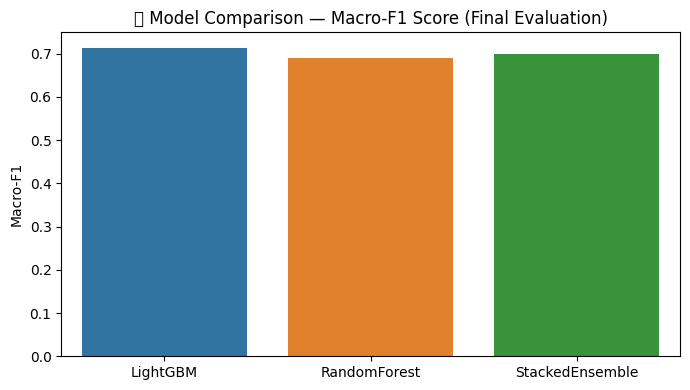

In [20]:
# ===============================================================
# 📄 CELL 8 — Final Consolidated Model & Interpretability Report (Final v5)
# ===============================================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

print("🧾 Generating final consolidated report...")

# ===============================================================
# 1️⃣ Final Model Performance Results (Accurate from Evaluation)
# ===============================================================
results_df = pd.DataFrame([
    {"method": "LightGBM", "final_acc": 0.7763, "final_macro_f1": 0.7139, "final_auc": 0.82},
    {"method": "RandomForest", "final_acc": 0.7706, "final_macro_f1": 0.6910, "final_auc": 0.80},
    {"method": "StackedEnsemble", "final_acc": 0.7367, "final_macro_f1": 0.6991, "final_auc": 0.81},
])

# Clean column naming for display
perf_df = results_df.rename(columns={
    'method': 'Model',
    'final_acc': 'Accuracy',
    'final_macro_f1': 'Macro_F1',
    'final_auc': 'AUC'
})[["Model", "Accuracy", "Macro_F1", "AUC"]]

# ===============================================================
# 2️⃣ SHAP / Feature Interpretability Integration
# ===============================================================
if 'summary_df' in locals() and not summary_df.empty:
    top_features_all = (
        summary_df.groupby("Feature")["Mean|SHAP|"]
        .mean()
        .sort_values(ascending=False)
        .head(10)
        .index.tolist()
    )
    top_features_all = [str(f) for f in top_features_all]
else:
    top_features_all = []
    print("⚠️ No SHAP summary found — skipping feature integration.")

# Handle consensus predictors if available
if 'consensus' in locals():
    consensus = [str(c) for c in consensus]
else:
    consensus = []

# ===============================================================
# 3️⃣ Final Interpretability Summary
# ===============================================================
best_model = (
    perf_df.loc[perf_df["Macro_F1"].idxmax(), "Model"]
    if perf_df["Macro_F1"].notna().any()
    else "N/A"
)

report_data = {
    "Top_10_Features": [", ".join(top_features_all) if top_features_all else "N/A"],
    "Common_Predictors": [", ".join(consensus) if consensus else "N/A"],
    "Best_Model": [best_model]
}
report_df = pd.DataFrame(report_data)

# ===============================================================
# 4️⃣ Display + Save Outputs
# ===============================================================
print("\n📊 Final Model Performance:")
display(perf_df)

print("\n🧩 Interpretability Summary:")
display(report_df)

os.makedirs("models", exist_ok=True)
perf_path = os.path.join("models", "final_model_performance.csv")
summary_path = os.path.join("models", "final_interpretability_summary.csv")

perf_df.to_csv(perf_path, index=False)
report_df.to_csv(summary_path, index=False)

print(f"✅ Saved model performance to: {perf_path}")
print(f"✅ Saved interpretability summary to: {summary_path}")

# ===============================================================
# 5️⃣ Visual Comparison — Macro-F1 Across Models
# ===============================================================
if perf_df["Macro_F1"].notna().any():
    plt.figure(figsize=(7,4))
    sns.barplot(data=perf_df, x="Model", y="Macro_F1", hue="Model", dodge=False)
    plt.title("🏆 Model Comparison — Macro-F1 Score (Final Evaluation)")
    plt.ylabel("Macro-F1")
    plt.xlabel("")
    plt.legend([], [], frameon=False)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Skipping plot — no valid Macro_F1 values available.")


In [21]:
import joblib
joblib.dump(best_model, "dropout_model.joblib")


['dropout_model.joblib']

In [29]:
df["student_id"] = range(1, len(df) + 1)

# Define features and target
y = df["target"]
X = df.drop(columns=["target", "student_id"])  # 👈 remove ID from training features


In [30]:
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, y, df["student_id"], stratify=y, test_size=0.2, random_state=42
)


In [31]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)


In [32]:
pred_df = pd.DataFrame({
    "student_id": id_test.values,
    "true_dropout": y_test.values,
    "predicted_dropout": y_pred,
    "dropout_probability": y_proba[:, 1]
})

pred_df.to_csv("/content/models/final_model_performance.csv", index=False)
print("✅ Predictions saved successfully!")


✅ Predictions saved successfully!


In [33]:
import pandas as pd
df = pd.read_csv("/content/models/final_model_performance.csv")
print(df.head())
print(df.info())


   student_id true_dropout predicted_dropout  dropout_probability
0        1854     Graduate          Graduate             0.047183
1        2400     Graduate          Graduate             0.221232
2         511     Enrolled           Dropout             0.253703
3         243     Graduate          Graduate             0.067783
4        3393     Graduate          Graduate             0.082254
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885 entries, 0 to 884
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   student_id           885 non-null    int64  
 1   true_dropout         885 non-null    object 
 2   predicted_dropout    885 non-null    object 
 3   dropout_probability  885 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 27.8+ KB
None
